# Import necessary libraries


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from math import sqrt
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

## Load the CocaCola prices dataset 

In [2]:
data = pd.read_excel('../Datasets/CocaCola_Sales_Rawdata.xlsx')


In [3]:
data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


## Data Preprocessing

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 804.0+ bytes


In [5]:
data.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [6]:
data.isna().sum().sum()

0

In [7]:
data.duplicated().sum()

0

In [9]:
#Clean way to convert quarterly periods to datetime in pandas
data['Quarter_Year'] = data['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
data.head()

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987


In [10]:
# Converting into datetime formate as the index was not in correct formate.
data['Date'] = (pd.to_datetime(data['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),dayfirst=True))
data.head()

,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01


In [11]:
## Drop unnecessary columns

data.drop(['Quarter','Quarter_Year'] , axis =1, inplace = True)
data.head()

,Sales,Date
0,1734.827000,1986-01-01
1,2244.960999,1986-04-01
2,2533.804993,1986-07-01
3,2154.962997,1986-10-01
4,1547.818996,1987-01-01


In [12]:
# Set 'Date' as the index
data.set_index('Date', inplace=True)

In [13]:
data.head()

,Sales
Date,
1986-01-01,1734.827000
1986-04-01,2244.960999
1986-07-01,2533.804993
1986-10-01,2154.962997
1987-01-01,1547.818996


## Visualization

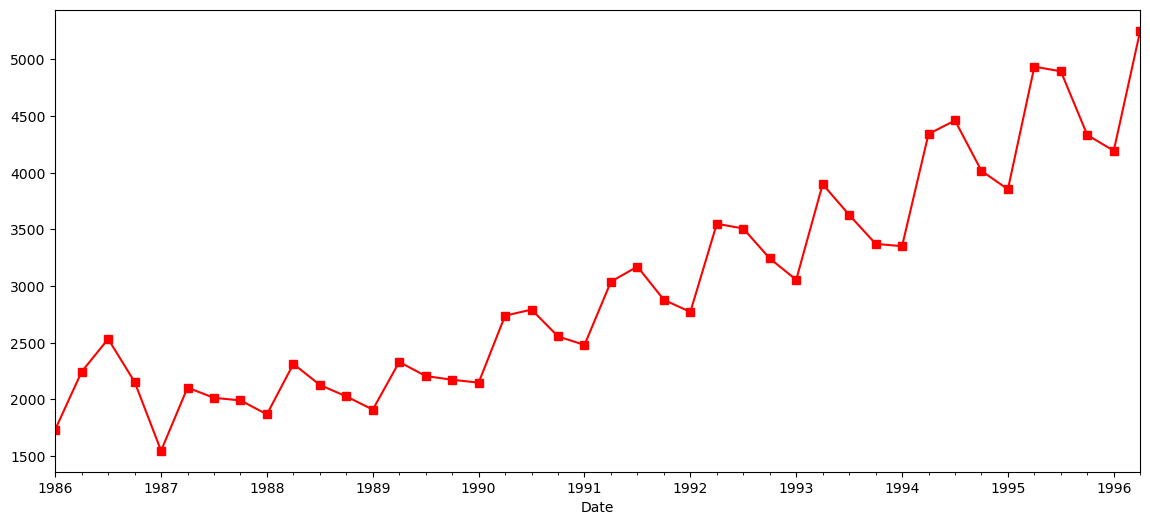

In [14]:
data['Sales'].plot(figsize=(14,6), color='red', marker='s')
plt.show()

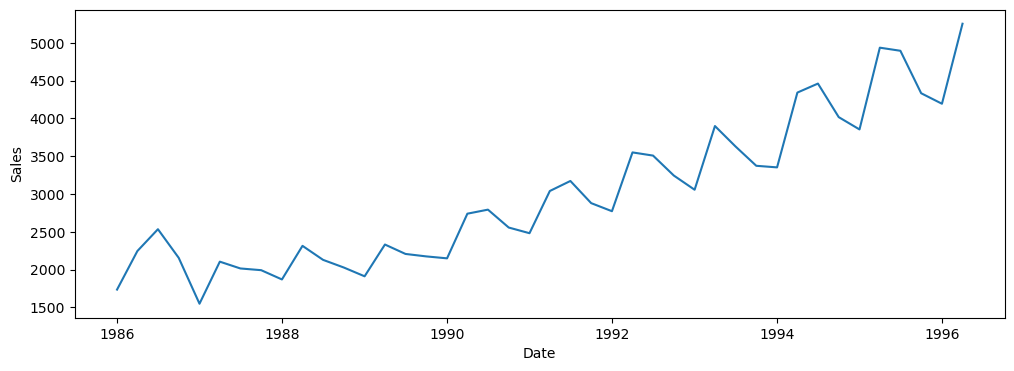

In [15]:

plt.figure(figsize=(12,4))
sns.lineplot(x="Date", y="Sales", data=data)
plt.show()

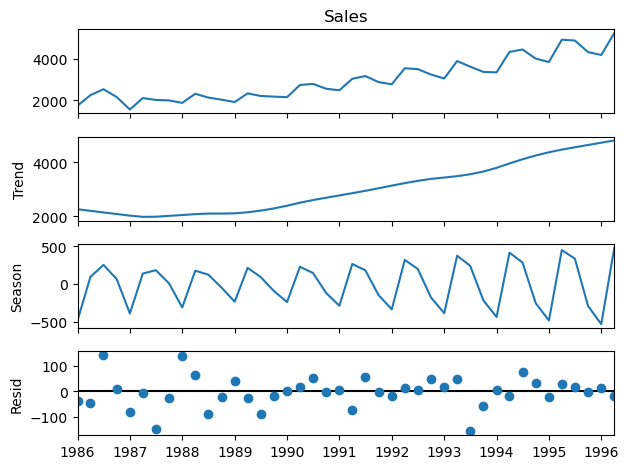

In [16]:
from statsmodels.tsa.seasonal import STL
df = STL(data['Sales']).fit()
df.plot()
plt.show()

## Model Buliding

In [17]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:]

In [18]:
train.shape,test.shape

((33, 1), (9, 1))

In [19]:
# Feature engineering: Create lag features for time series forecasting
train['Price_Lag1'] = train['Sales'].shift(1)
test['Price_Lag1'] = test['Sales'].shift(1)


In [20]:
train.head()

,Sales,Price_Lag1
Date,,
1986-01-01,1734.827000,NaN
1986-04-01,2244.960999,1734.827000
1986-07-01,2533.804993,2244.960999
1986-10-01,2154.962997,2533.804993
1987-01-01,1547.818996,2154.962997


In [21]:
test.head()

,Sales,Price_Lag1
Date,,
1994-04-01,4342.0,NaN
1994-07-01,4461.0,4342.0
1994-10-01,4017.0,4461.0
1995-01-01,3854.0,4017.0
1995-04-01,4936.0,3854.0


In [22]:
# Drop NaN values
train.dropna(inplace=True)
test.dropna(inplace=True)

In [23]:
# Define features and target variable
X_train = train[['Price_Lag1']]
y_train = train['Sales']
X_test = test[['Price_Lag1']]
y_test = test['Sales']

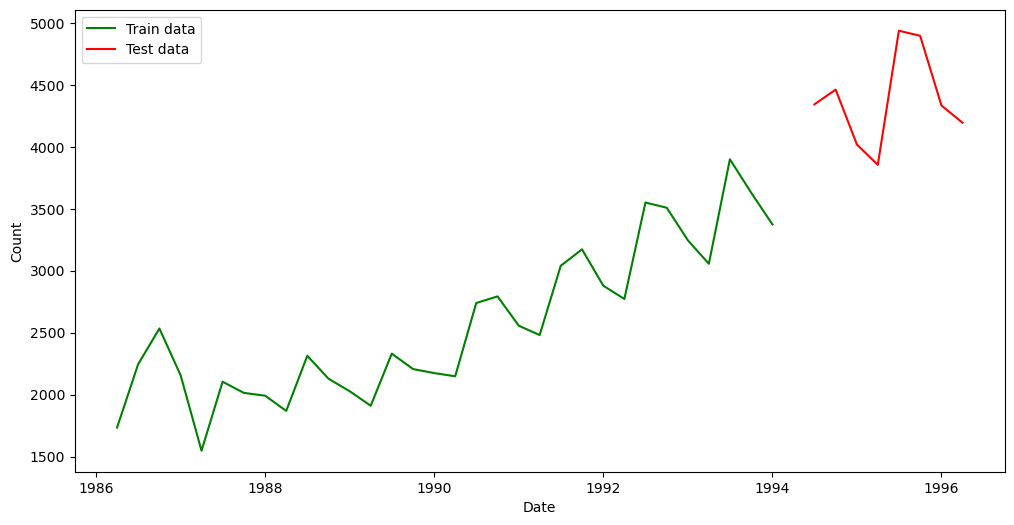

In [24]:
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(X_train, 'green', label='Train data')
plt.plot(X_test, 'red', label='Test data')
plt.legend()
plt.show()

##  Linear Regression



In [25]:
# Train the linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [26]:
# Make predictions on the test set
predictions_lr = model_lr.predict(X_test)

In [27]:
predictions_lr

array([4081.69101637, 4179.8578853 , 3813.58822306, 3679.12436058,
       4571.70042936, 4537.87823082, 4074.26663132, 3959.60112896])

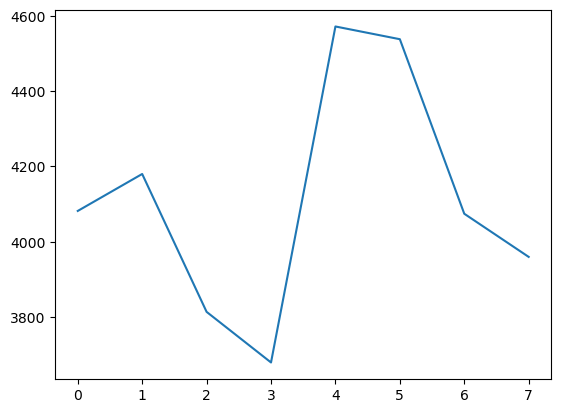

In [28]:

plt.plot(predictions_lr )
plt.show()

In [29]:
model_residuals = pd.DataFrame(index=['MSE','RMSE','MAE','MAPE'])

In [30]:
# Evaluate the linear regression model
mse_lr = mean_squared_error(y_test,predictions_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test,predictions_lr)
mape_lr = mean_absolute_percentage_error(y_test,predictions_lr)
model_residuals['Predict'] = [mse_lr,rmse_lr,mae_lr,mape_lr]
model_residuals

,Predict
MSE,448185.237699
RMSE,669.466383
MAE,472.595541
MAPE,0.097349


## Random Forest Regression

In [31]:
# Train the random forest regression model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [32]:
# Make predictions on the test set
predictions_rf = model_rf.predict(X_test)

In [33]:
predictions_rf

array([3548.06579979, 3548.06579979, 3548.06579979, 3548.06579979,
       3548.06579979, 3548.06579979, 3548.06579979, 3548.06579979])

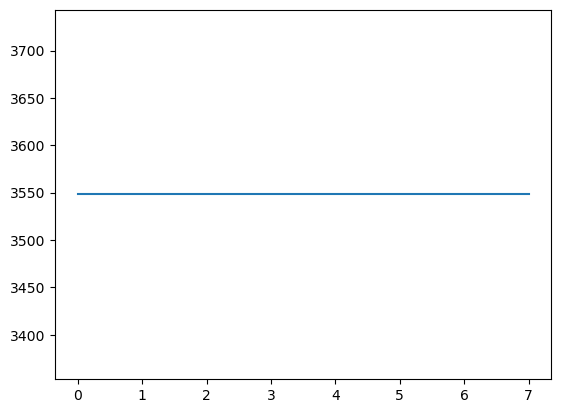

In [34]:
plt.plot(predictions_rf )
plt.show()

In [35]:
# Evaluate the linear regression model
mse_rf = mean_squared_error(y_test,predictions_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test,predictions_rf)
mape_rf = mean_absolute_percentage_error(y_test,predictions_rf)
model_residuals['Predict'] = [mse_rf,rmse_rf,mae_rf,mape_rf]
model_residuals

,Predict
MSE,1.103461e+06
RMSE,1.050458e+03
MAE,9.448092e+02
MAPE,2.021060e-01


## Plotting actual vs. predicted values

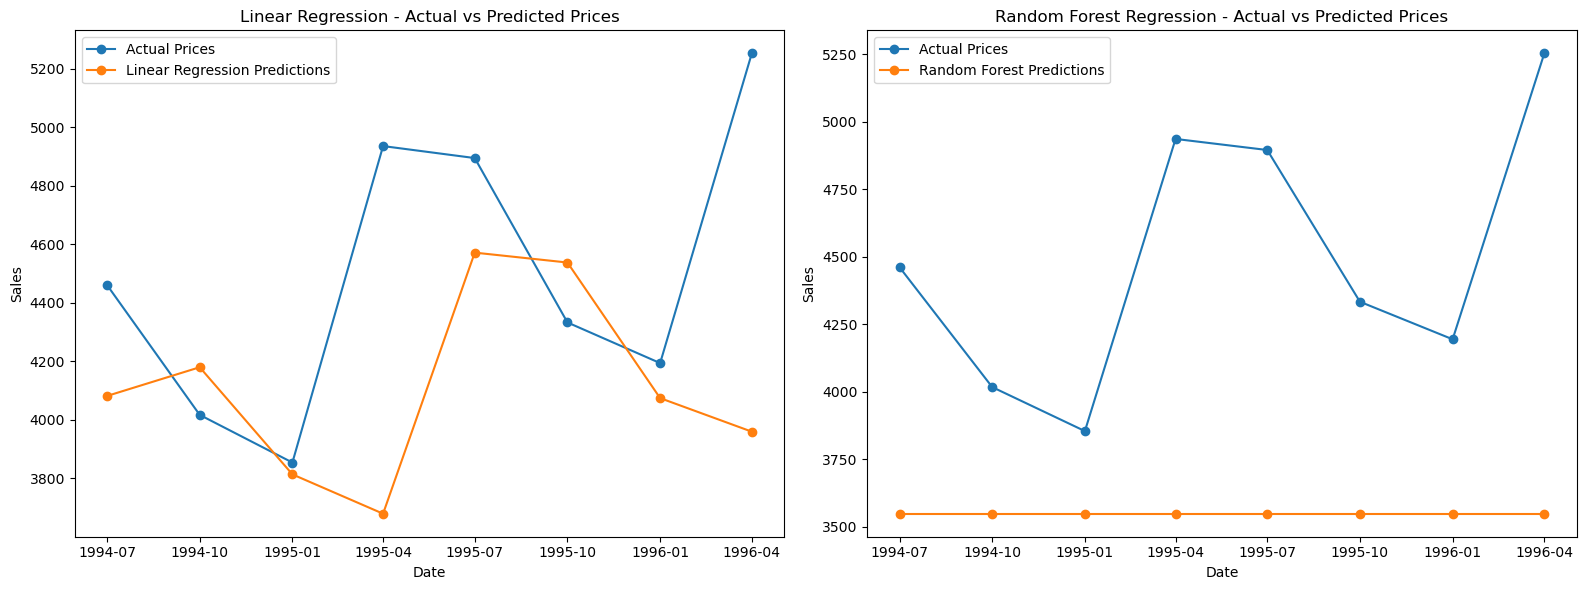

In [36]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(test.index, y_test, label='Actual Prices', marker='o')
plt.plot(test.index, predictions_lr, label='Linear Regression Predictions', marker='o')
plt.title('Linear Regression - Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test.index, y_test, label='Actual Prices', marker='o')
plt.plot(test.index, predictions_rf, label='Random Forest Predictions', marker='o')
plt.title('Random Forest Regression - Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

plt.tight_layout()
plt.show()

## Model Explanation Document



In [37]:
# Linear Regression Explanation
linear_regression_document = """
Linear Regression Model:

Dummy Variables: No dummy variables were created in this model.

RMSE Value: {}
""".format(rmse_lr)

In [38]:
# Random Forest Regression Explanation
random_forest_document = """
Random Forest Regression Model:

Dummy Variables: No dummy variables were created in this model.

RMSE Value: {}
""".format(rmse_rf)

## Conclusion

In [39]:
# Choose the model with the lowest RMSE
if rmse_lr < rmse_rf:
    chosen_model = "Linear Regression"
    final_model = model_lr
    explanation_document = linear_regression_document
else:
    chosen_model = "Random Forest Regression"
    final_model = model_rf
    explanation_document = random_forest_document


In [40]:
# Print the chosen model
print(f"The chosen model for forecasting is: {chosen_model}")

The chosen model for forecasting is: Linear Regression


In [41]:
# Optionally, you can further analyze the final model (coefficients, etc.)
print(final_model.coef_) 

[0.82493167]


In [42]:
# Print the explanation document
print(explanation_document)


Linear Regression Model:

Dummy Variables: No dummy variables were created in this model.

RMSE Value: 669.4663827997076

